# Machine Learning Analysis: SVR and Random Forest Models

This notebook combines and improves upon the analysis of:
1. Support Vector Regression (SVR)
2. Random Forest Regression

We'll go through the following steps:
1. Data Loading and Preprocessing
2. SVR Analysis
   - Hyperparameter Optimization
   - Cross-validation Results
   - Model Interpretation
3. Random Forest Analysis
   - Hyperparameter Optimization
   - Cross-validation Results
   - Tree Visualization
4. Model Comparison

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree

# Set random seed for reproducibility
np.random.seed(42)

## 2. Utility Functions

In [2]:
def plot_parity(y_true, y_pred, y_train=None, y_pred_train=None, label=None, ylim=[-12,12]):
    """Create parity plots comparing true vs predicted values.
    
    Parameters:
    -----------
    y_true : array-like
        True target values for validation/test set
    y_pred : array-like
        Predicted values for validation/test set
    y_train : array-like, optional
        True target values for training set
    y_pred_train : array-like, optional
        Predicted values for training set
    label : str, optional
        Label for the plot
    ylim : list, optional
        Y-axis limits for the plot
    """
    
    rmse_test = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_test = r2_score(y_true, y_pred)

    if y_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    # Test/Validation plot
    ax1.scatter(y_true, y_pred, alpha=0.5)
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title(f'{label} Set\nRMSE: {rmse_test:.2f}, R²: {r2_test:.2f}')
    ax1.set_xlim(ylim)
    ax1.set_ylim(ylim)

    # Training plot if provided
    if y_train is not None:
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_train = r2_score(y_train, y_pred_train)
        
        ax2.scatter(y_train, y_pred_train, alpha=0.5, color='orange')
        ax2.plot(ylim, ylim, '--k')
        ax2.set_xlabel('True Values')
        ax2.set_ylabel('Predicted Values')
        ax2.set_title(f'Training Set\nRMSE: {rmse_train:.2f}, R²: {r2_train:.2f}')
        ax2.set_xlim(ylim)
        ax2.set_ylim(ylim)

    plt.tight_layout()
    plt.show()

def plot_model_predictions(X, y, model, title, show_training=True):
    """Plot model predictions against training data.
    
    Parameters:
    -----------
    X : array-like
        Input features
    y : array-like
        Target values
    model : sklearn estimator
        Fitted model
    title : str
        Plot title
    show_training : bool, optional
        Whether to show training data points
    """
    x_test = np.linspace(X.min()-1, X.max()+1, 200).reshape(-1, 1)
    y_pred = model.predict(x_test)
    
    plt.figure(figsize=(10, 6))
    if show_training:
        plt.scatter(X, y, alpha=0.5, label='Training Data')
    plt.plot(x_test, y_pred, 'r-', label='Model Predictions')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 3. Load and Prepare Data

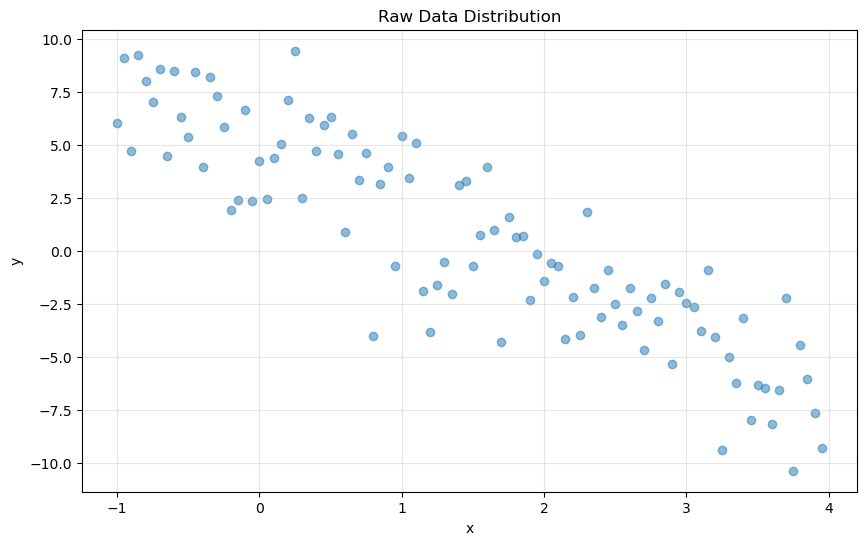

In [3]:

# Load and prepare data
data = pd.read_csv('data\LR_1D_data.csv')
data = data.sample(frac=1, random_state=42)  # Shuffle data

X = data['x'].values.reshape(-1, 1)
y = data['y'].values

# Visualize raw data
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Raw Data Distribution')
plt.grid(True, alpha=0.3)
plt.show()

## 4. Support Vector Regression (SVR) Analysis

### 4.1 SVR Hyperparameter Optimization

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best SVR Parameters: {'C': 10, 'epsilon': 2.5, 'gamma': 'scale', 'kernel': 'linear'}
Best CV RMSE: 2.2653183903197713


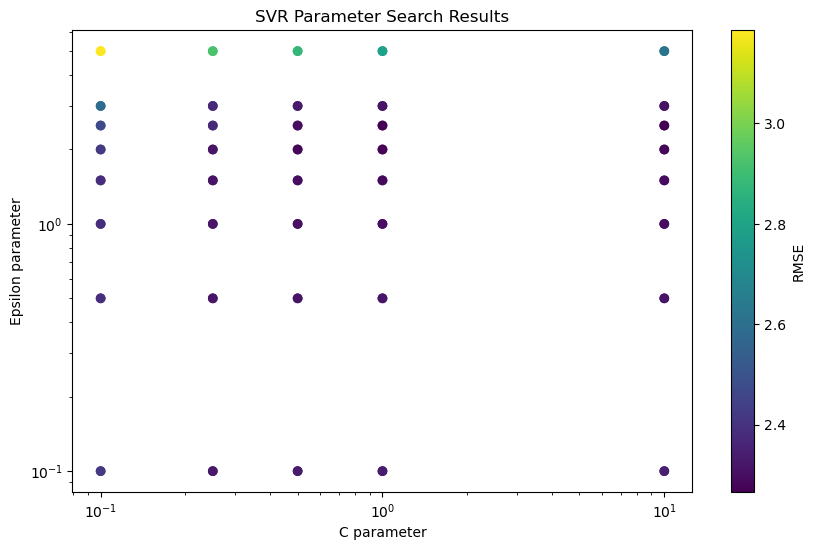

In [4]:
# Define parameter grid for SVR
svr_param_grid = {
    'C': [0.1, 0.25, 0.5, 1, 10],
    'epsilon': [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 5],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto']
}

# Perform grid search
svr = SVR()
svr_grid_search = GridSearchCV(
    svr, 
    svr_param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
svr_grid_search.fit(X, y)

# Print best parameters and score
print("Best SVR Parameters:", svr_grid_search.best_params_)
print("Best CV RMSE:", np.sqrt(-svr_grid_search.best_score_))

# Visualize parameter search results
results_df = pd.DataFrame(svr_grid_search.cv_results_)
plt.figure(figsize=(10, 6))
plt.scatter(
    results_df['param_C'],
    results_df['param_epsilon'],
    c=np.sqrt(-results_df['mean_test_score']),
    cmap='viridis'
)
plt.colorbar(label='RMSE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C parameter')
plt.ylabel('Epsilon parameter')
plt.title('SVR Parameter Search Results')
plt.show()

### 4.2 SVR Cross-validation Analysis

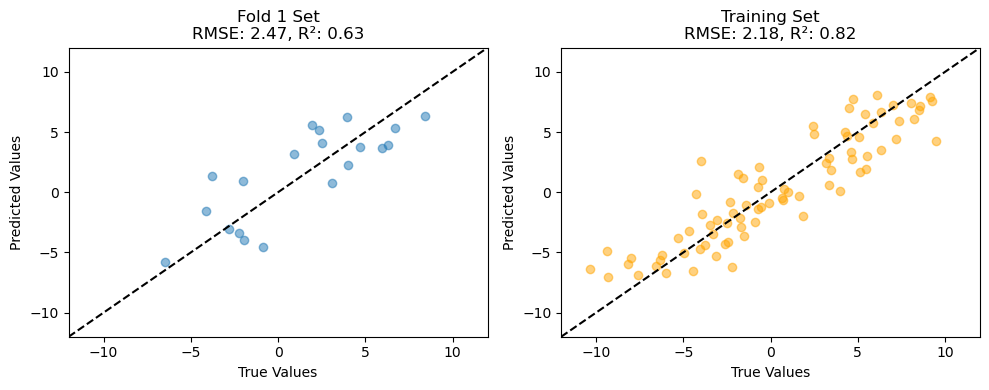

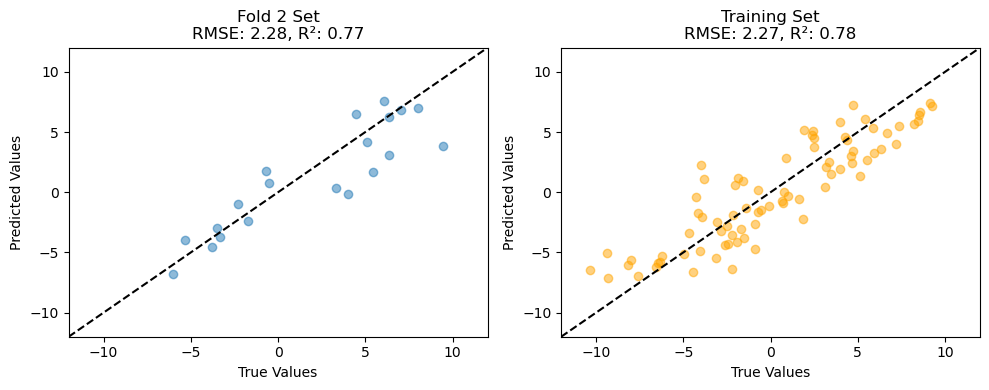

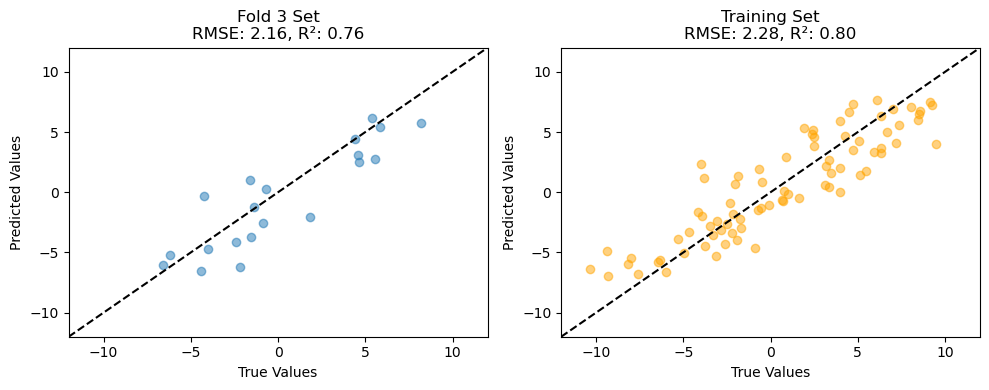

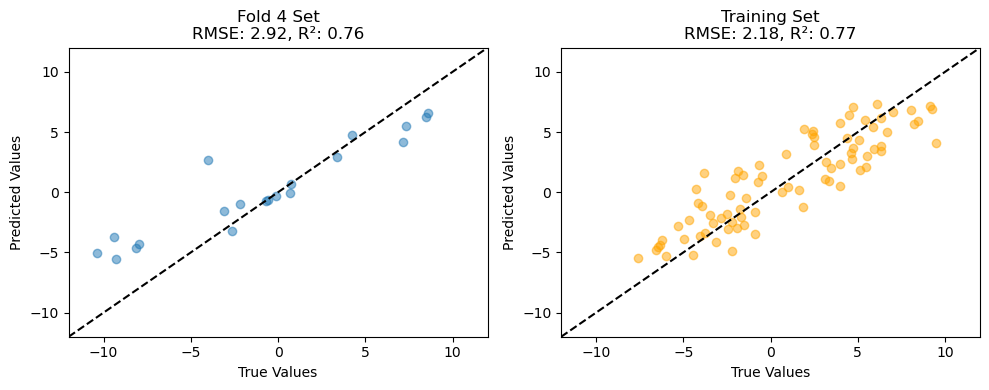

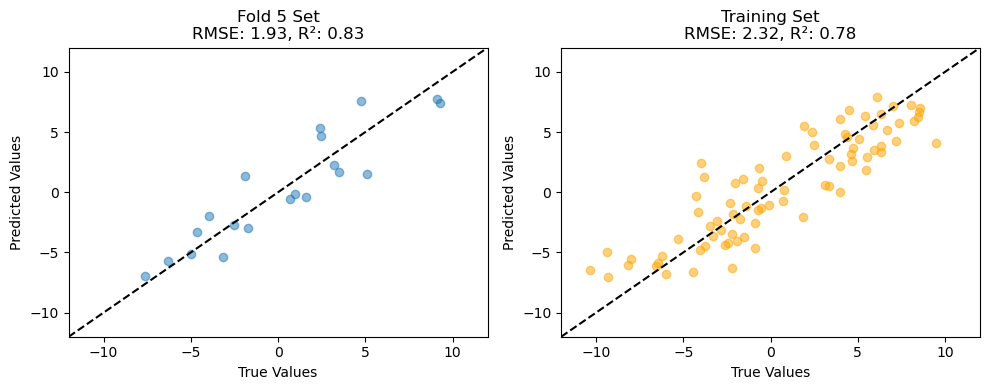


Cross-validation Summary:
fold          3.000000
train_rmse    2.246606
val_rmse      2.352473
train_r2      0.789591
val_r2        0.750077
dtype: float64


In [5]:
# Initialize best SVR model
best_svr = SVR(**svr_grid_search.best_params_)

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
svr_cv_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    # Split data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Train and predict
    best_svr.fit(X_train, y_train)
    y_train_pred = best_svr.predict(X_train)
    y_val_pred = best_svr.predict(X_val)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Store results
    svr_cv_results.append({
        'fold': fold,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2
    })
    
    # Plot results
    plot_parity(y_val, y_val_pred, y_train, y_train_pred, f'Fold {fold}')

# Display summary statistics
cv_df = pd.DataFrame(svr_cv_results)
print("\nCross-validation Summary:")
print(cv_df.mean())

### 4.3 Final SVR Model and Support Vector Analysis

Number of support vectors: 29
Total data points: 100

Model coefficients (w): [[-2.94946575]]
Bias term (b): [4.70810824]


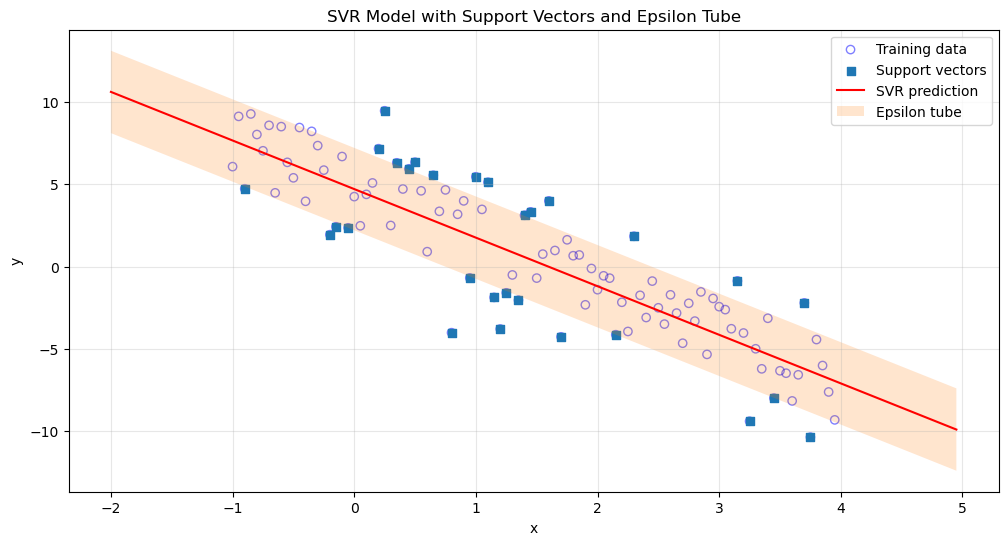

In [6]:
# Train final SVR model on all data
final_svr = SVR(**svr_grid_search.best_params_)
final_svr.fit(X, y)

# Print model information
print(f"Number of support vectors: {final_svr.n_support_[0]}")
print(f"Total data points: {len(X)}")

# Calculate model coefficients
w = np.dot(final_svr.dual_coef_, final_svr.support_vectors_)
b = final_svr.intercept_
print(f"\nModel coefficients (w): {w}")
print(f"Bias term (b): {b}")

# Visualize model predictions and support vectors
x_test = np.linspace(X.min()-1, X.max()+1, 200).reshape(-1, 1)
y_pred = final_svr.predict(x_test)

plt.figure(figsize=(12, 6))
plt.scatter(X, y, facecolors='none', edgecolors='b', label='Training data', alpha=0.5)
plt.scatter(X[final_svr.support_], y[final_svr.support_], 
           label='Support vectors', marker='s')
plt.plot(x_test, y_pred, 'r-', label='SVR prediction')
plt.fill_between(x_test.ravel(), 
                 y_pred - final_svr.epsilon, 
                 y_pred + final_svr.epsilon, 
                 alpha=0.2, 
                 label='Epsilon tube')
plt.xlabel('x')
plt.ylabel('y')
plt.title('SVR Model with Support Vectors and Epsilon Tube')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Random Forest Analysis

### 5.1 Random Forest Hyperparameter Optimization

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best RF Parameters: {'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best CV RMSE: 2.425756838038366


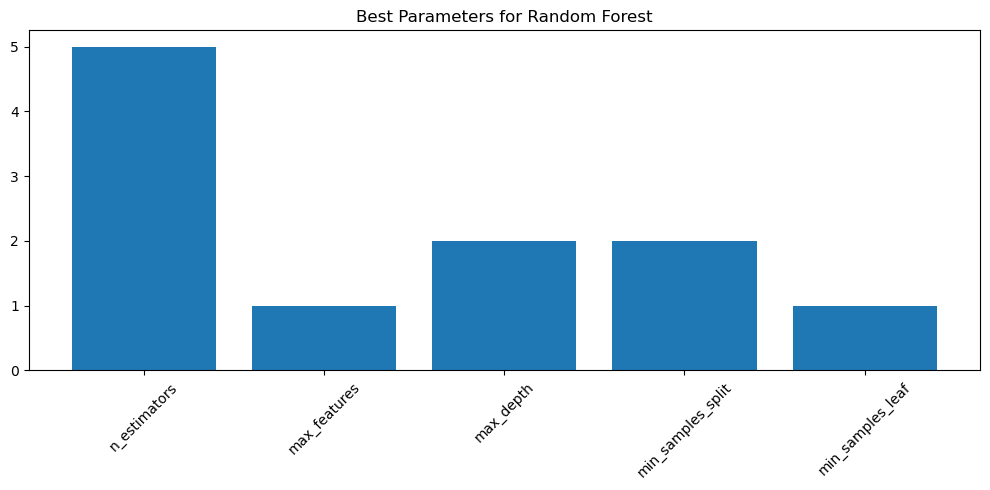

In [7]:
# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [5, 10, 50],
    'max_features': [1],
    'max_depth': [2, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
rf = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(
    rf, 
    rf_param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
rf_grid_search.fit(X, y)

# Print best parameters and score
print("Best RF Parameters:", rf_grid_search.best_params_)
print("Best CV RMSE:", np.sqrt(-rf_grid_search.best_score_))

# Visualize parameter importance
results_df = pd.DataFrame(rf_grid_search.cv_results_)
param_scores = {
    param: results_df[f'param_{param}'].value_counts().index[0]
    for param in rf_param_grid.keys()
}

plt.figure(figsize=(10, 5))
plt.bar(param_scores.keys(), param_scores.values())
plt.xticks(rotation=45)
plt.title('Best Parameters for Random Forest')
plt.tight_layout()
plt.show()

### 5.2 Random Forest Cross-validation Analysis

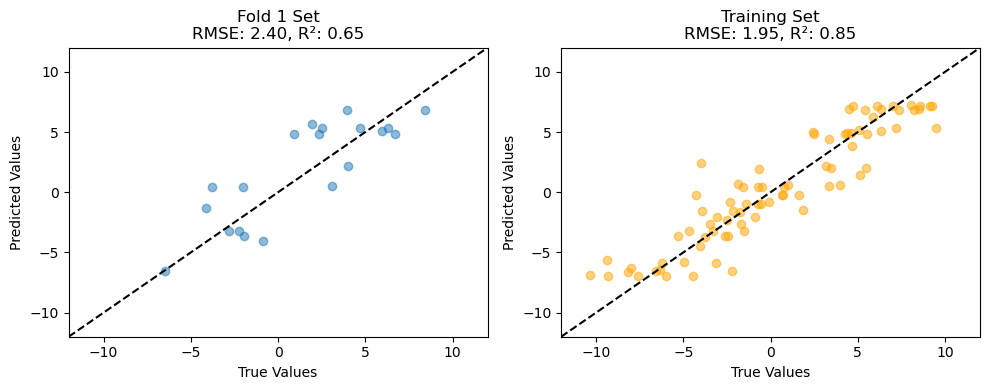

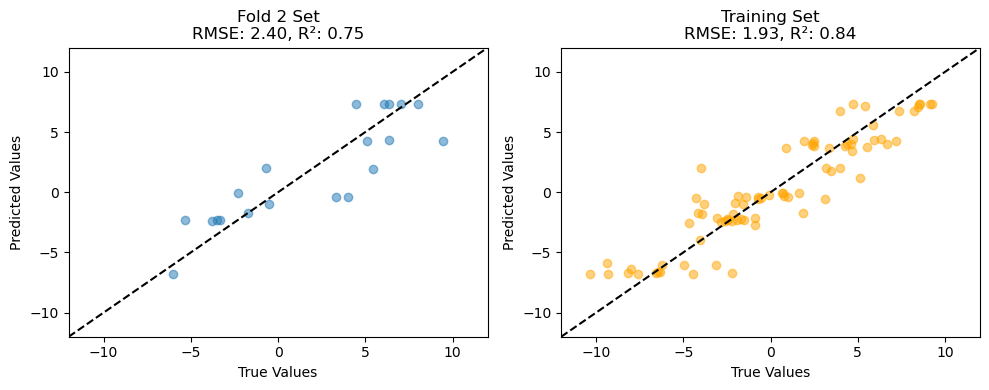

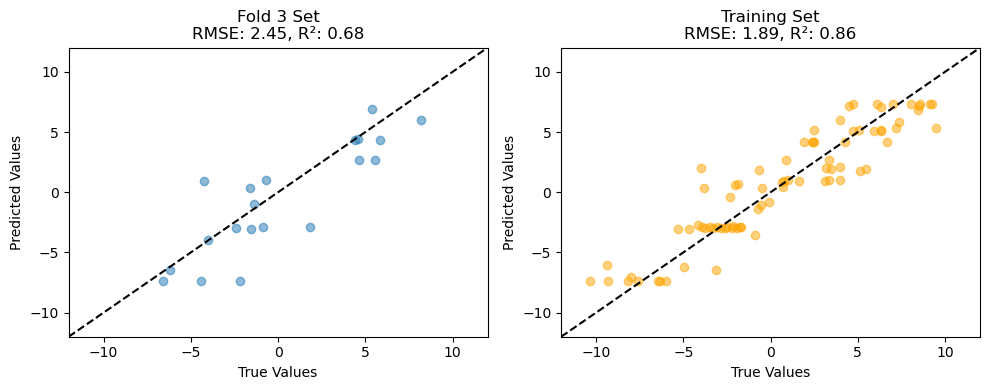

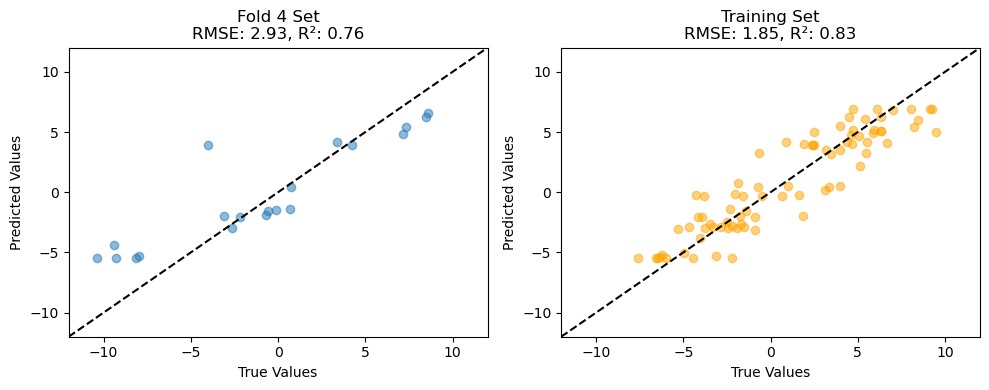

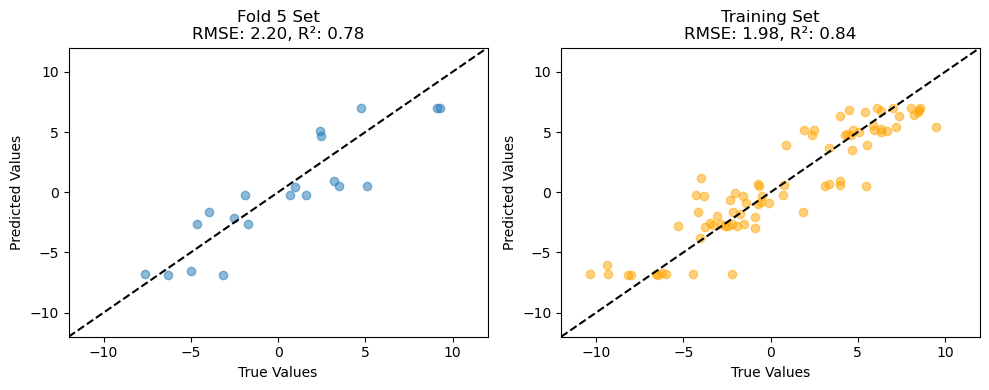


Cross-validation Summary:
fold          3.000000
train_rmse    1.920369
val_rmse      2.476688
train_r2      0.846447
val_r2        0.724521
dtype: float64


In [8]:
# Initialize best RF model
best_rf = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42)

# Perform k-fold cross-validation
rf_cv_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    # Split data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Train and predict
    best_rf.fit(X_train, y_train)
    y_train_pred = best_rf.predict(X_train)
    y_val_pred = best_rf.predict(X_val)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Store results
    rf_cv_results.append({
        'fold': fold,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2
    })
    
    # Plot results
    plot_parity(y_val, y_val_pred, y_train, y_train_pred, f'Fold {fold}')

# Display summary statistics
cv_df = pd.DataFrame(rf_cv_results)
print("\nCross-validation Summary:")
print(cv_df.mean())

### 5.3 Final Random Forest Model Analysis

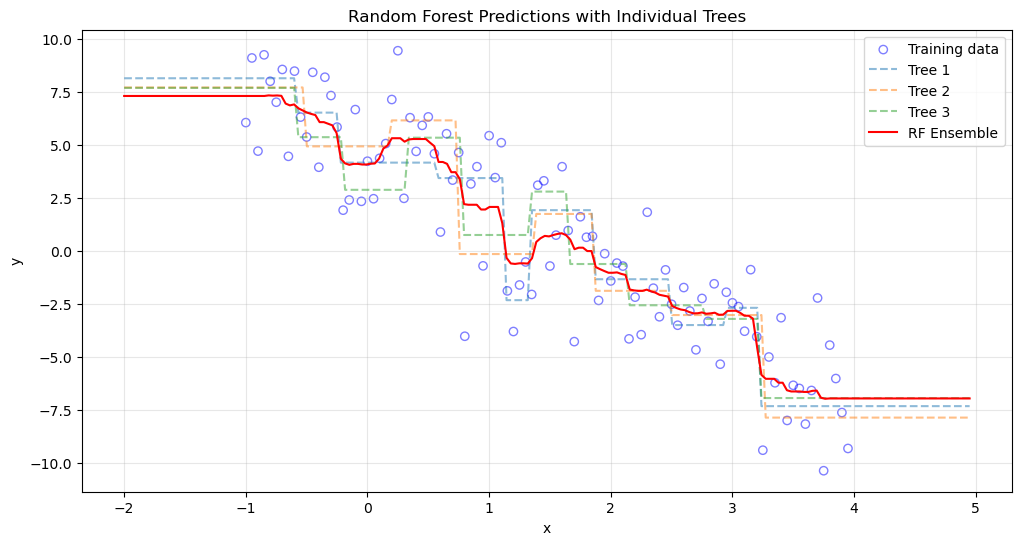

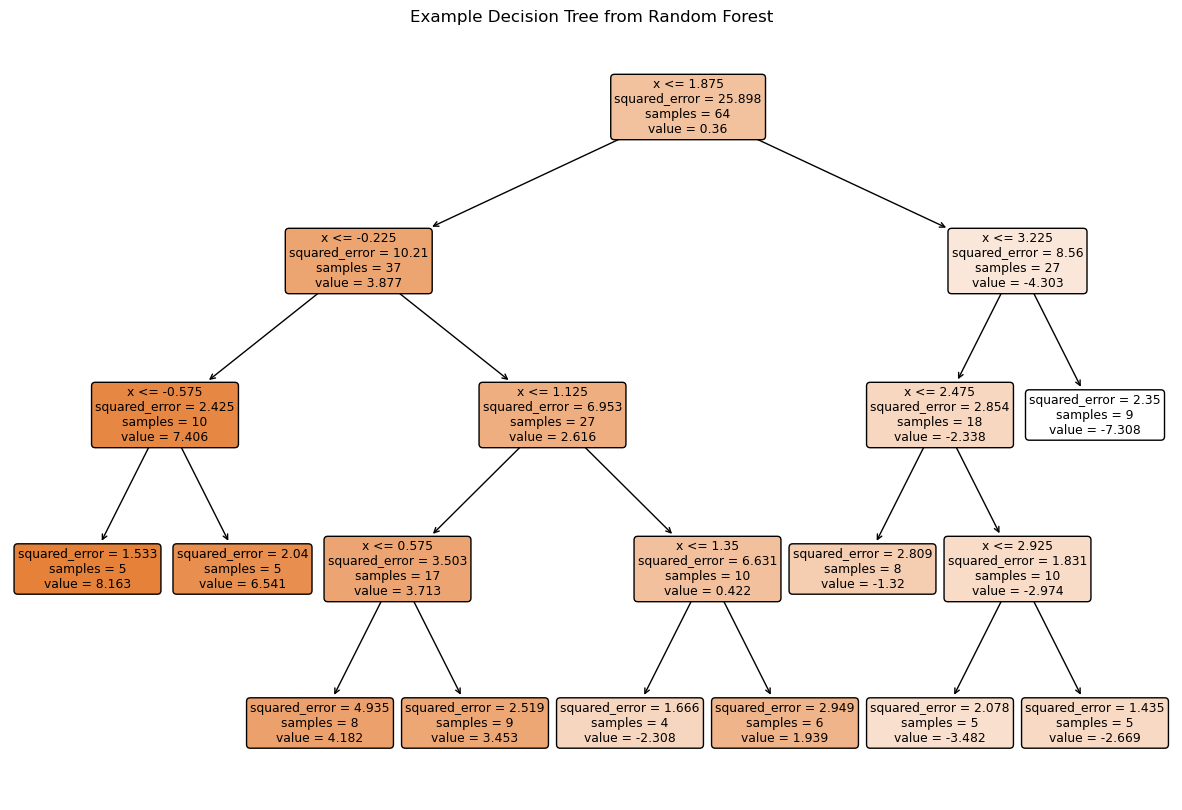

In [9]:
# Train final RF model on all data
final_rf = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42)
final_rf.fit(X, y)

# Visualize individual trees and ensemble prediction
x_test = np.linspace(X.min()-1, X.max()+1, 200).reshape(-1, 1)
y_pred_rf = final_rf.predict(x_test)

plt.figure(figsize=(12, 6))
plt.scatter(X, y, facecolors='none', edgecolors='b', label='Training data', alpha=0.5)

# Plot individual tree predictions
for idx in range(min(3, final_rf.n_estimators)):
    tree_pred = final_rf.estimators_[idx].predict(x_test)
    plt.plot(x_test, tree_pred, '--', alpha=0.5, label=f'Tree {idx+1}')

plt.plot(x_test, y_pred_rf, 'r-', label='RF Ensemble')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Random Forest Predictions with Individual Trees')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize a single decision tree
plt.figure(figsize=(15, 10))
tree.plot_tree(final_rf.estimators_[0], 
              feature_names=['x'],
              filled=True,
              rounded=True)
plt.title('Example Decision Tree from Random Forest')
plt.show()

## 6. Model Comparison and Analysis

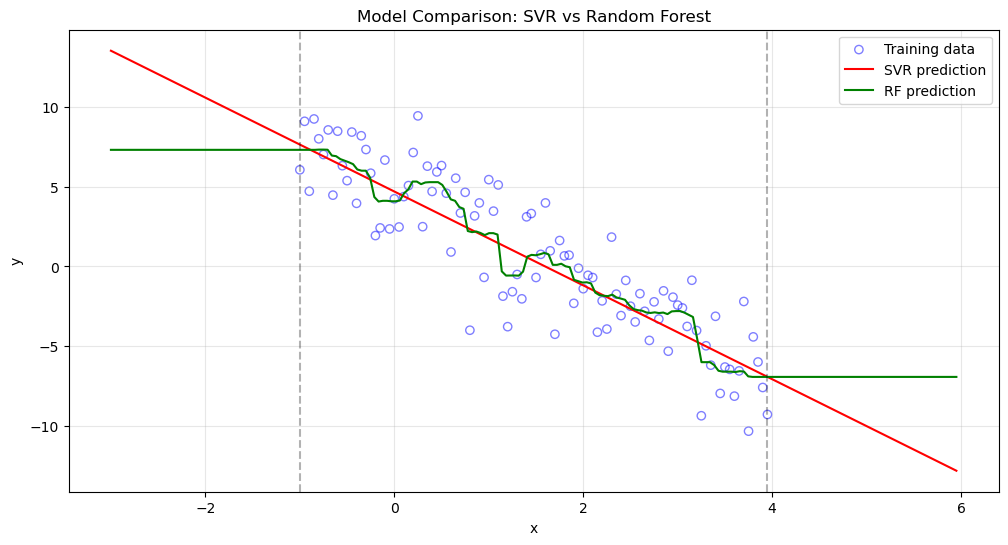


Model Comparison on Training Data:
SVR - RMSE: 2.26, R²: 0.79
RF  - RMSE: 1.92, R²: 0.85


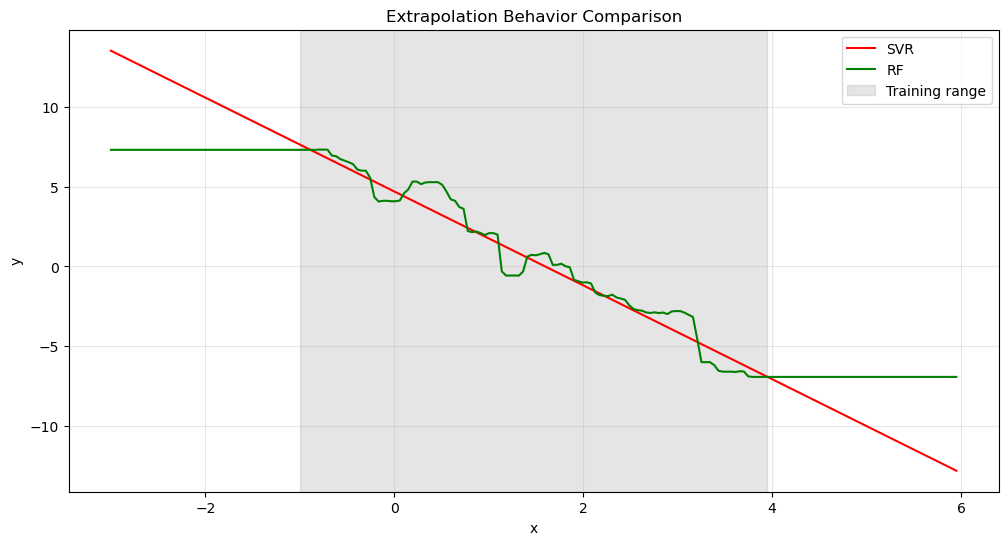

In [10]:
# Generate predictions for both models
x_test = np.linspace(X.min()-2, X.max()+2, 200).reshape(-1, 1)
y_pred_svr = final_svr.predict(x_test)
y_pred_rf = final_rf.predict(x_test)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.scatter(X, y, facecolors='none', edgecolors='b', label='Training data', alpha=0.5)
plt.plot(x_test, y_pred_svr, 'r-', label='SVR prediction')
plt.plot(x_test, y_pred_rf, 'g-', label='RF prediction')

# Add vertical lines for training data range
plt.axvline(X.min(), color='k', linestyle='--', alpha=0.3)
plt.axvline(X.max(), color='k', linestyle='--', alpha=0.3)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Comparison: SVR vs Random Forest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print comparison metrics on training data
svr_rmse = np.sqrt(mean_squared_error(y, final_svr.predict(X)))
rf_rmse = np.sqrt(mean_squared_error(y, final_rf.predict(X)))
svr_r2 = r2_score(y, final_svr.predict(X))
rf_r2 = r2_score(y, final_rf.predict(X))

print("\nModel Comparison on Training Data:")
print(f"SVR - RMSE: {svr_rmse:.2f}, R²: {svr_r2:.2f}")
print(f"RF  - RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")

# Analysis of extrapolation behavior
plt.figure(figsize=(12, 6))
plt.plot(x_test, y_pred_svr, 'r-', label='SVR')
plt.plot(x_test, y_pred_rf, 'g-', label='RF')
plt.axvspan(X.min(), X.max(), alpha=0.2, color='gray', label='Training range')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Extrapolation Behavior Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Key Observations

1. **SVR Model**:
   - Linear behavior in extrapolation
   - Consistent prediction uncertainty (epsilon tube)
   - Support vectors define the model boundary

2. **Random Forest**:
   - Constant predictions in extrapolation regions
   - More flexible in capturing local patterns
   - Individual trees show step-wise predictions

3. **Comparison**:
   - SVR provides smoother predictions
   - RF shows better local adaptation
   - Different extrapolation behaviors

4. **Limitations**:
   - RF cannot extrapolate beyond training range
   - SVR assumes linear relationship continues
   - Both models have their own bias-variance tradeoffs